# Machine Learning Model to Predict Colic Outcomes
The goal of this project is to develop a machine learning model to predict colic outcomes in horses. Colic itself is not an illness, but a set of symptoms associated with abdominal pain. However, the causes of the pain can range from an easily treatable case of bad gas to fatal without immediate surgical intervantion, such as when the intestines become twisted. 

Behaviors associated with colic include repeated pawing, looking at the side, kicking at the abdomen, laying down, rolling, and abnormal defecation. Since the cause of colic has the potential to be life-threatening, it is a serious concern for horse owners and caretakers and is treated as a medical emergency when it occurs.

**Disclaimer:** The author has no veterinary training, any insights this algorithm may produce do not constitute medical advice. If you think your horse is colicking, please contact a veterinary professional.

### About the Data
The data set was created by Mary McLeish and Matt Cecile of the University of Guelph, and the training data was downloaded from [Kaggle](https://www.kaggle.com/uciml/horse-colic). Testing data was provided at the original [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/47/horse+colic) and will be combined with the training set. This is done to provide the model with more data and allows for controlling the class imbalances between the two sets as-is, since the testing set contains no young horses and a much smaller number of negative outcomes compared to the Kaggle set.

It is worth noting that the data appears to be from 1989, so it may not be representative of colic outcomes today.

In [1]:
from colic_scripts import format_colic_data, clean_colic_data

import pandas as pd
pd.set_option('display.max_columns', 30)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Kaggle data import
df_1 = pd.read_csv('horse.csv')
df_1 = clean_colic_data(df_1, verify=False)
df_1.shape

(211, 19)

In [3]:
# UCI data formatting and import
df_2 = format_colic_data('UCI_data/horse-colic.test')
df_2 = clean_colic_data(df_2, verify=False)
df_2.shape

(51, 19)

In [4]:
df = pd.concat([df_1, df_2])
df.shape

(262, 19)

### Data Preparation

While the data set was previously cleaned, there are a few more steps needed to make it more appropriate for use with the machine learning model. First, the `outcome` column will be used to create a new `survived` column, where 1 represents horses that lived, and 0 represents horses that died. This column will be the target column.

Euthanized horses will be removed from the data, because while these horses ultimately died, there are many reasons why euthanasia is chosen. These include reducing the suffering of a horse who will likely die anyway, concerns about recovery or future quality of life, and the cost of continued treatment and/or surgery. Since there is no information as to why euthanasia was chosen, these cases may throw off the model's predictions.

In [5]:
def clean_target_column(df, val_counts=True):
    """
    Creates the 'survived' target column for the input dataframe

    Args:
    df (DataFrame) : The dataframe to clean, assumed to contain an 'outcome' column with values in ['euthanized', 'died'].
    val_counts (bool) : Optional, default is True. Whether to print normalized value counts of 'survived' column.

    Returns:
    The input dataframe with 'survived' column added, and 'outcome' column removed.
    """
    df['survived'] =  1
    df.loc[df['outcome'] == 'euthanized', 'survived'] = np.nan
    df.loc[df['outcome'] == 'died', 'survived'] = 0
    df.drop('outcome', axis=1, inplace=True)
    df.dropna(inplace=True)
    
    if val_counts:
        print(df.survived.value_counts(normalize=True))
    
    return df

In [6]:
df = clean_target_column(df)

survived
1.0    0.716157
0.0    0.283843
Name: proportion, dtype: float64


Now, the categorical columns will be made into binary columns using dummies. These columns include:
* `surgery`
* `age`
* `temp_of_extremities`
* `peripheral_pulse`
* `mucous_membrane`
* `capillary_refill_time`
* `peristalsis`
* `rectal_exam_feces`
* `abdomen`

In [7]:
df = pd.get_dummies(df, drop_first=True)

While the drop_first argument removes one instance of highly correlated variables, a correlation heatmap helps visualize any that remain.

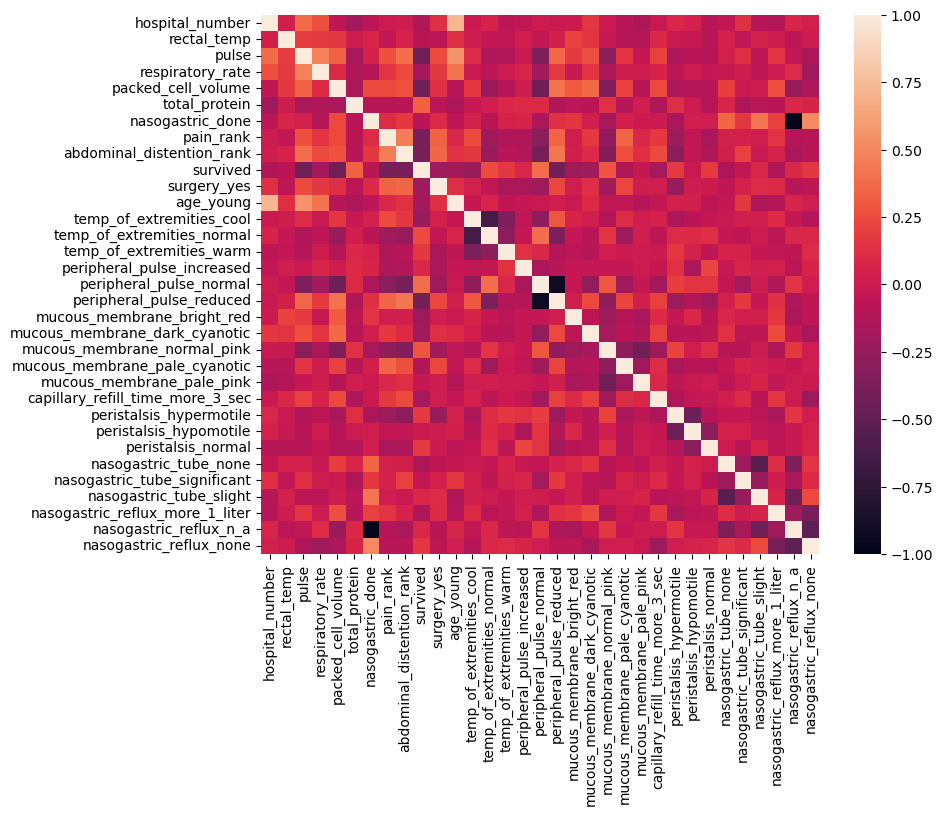

In [8]:
corr = df.corr()
plt.figure(figsize=(9,7))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Based on the heatmap, the `nasogastric_done` and `peripheral_pulse_normal` columns can be dropped due to high correlation with other variables. Removing `nasogastric_done` does make sense, since whether or not a diagnostic procedure was performed should have no effect on survival.

In [9]:
df = df.drop(['nasogastric_done', 'peripheral_pulse_normal'], axis=1)

Next, the numerical columns are rescaled. This is so that larger numbers, like temperature, don't influence the model simply because of their relative magnitude. To prevent data leakage, the train and test sets will be split before rescaling.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = df.columns
features = features.drop(['hospital_number', 'survived'])

X_train, X_test, y_train, y_test = train_test_split(df[features], df['survived'], test_size=0.3, random_state=34, stratify=df['survived'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Machine Learning Model
A logistic regression model was chosen because predicting the survival column is a binary classification problem. The F1 score is chosen as the metric for evaluating the model, since it balances precision (true positives out of all predicted positives) and recall (true positives out of all real positives).

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
predictions = lr.predict(X_test_scaled)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        20
         1.0       0.88      0.88      0.88        49

    accuracy                           0.83        69
   macro avg       0.79      0.79      0.79        69
weighted avg       0.83      0.83      0.83        69



An F1 score of 0.88 for the positive class indicates that the model is good at predicting which horses will survive. But since the data mostly contains horses that lived, the model could simply output a lot of positive results to perform well, regardless of the data itself. The F1 score of the negative class is 0.70, which shows that the model performs worse at accurately predicting which horses die.